In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

for gpu in tf.config.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)
keras = tf.keras

In [11]:
def trend(time, slope=0):
    return slope * time

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

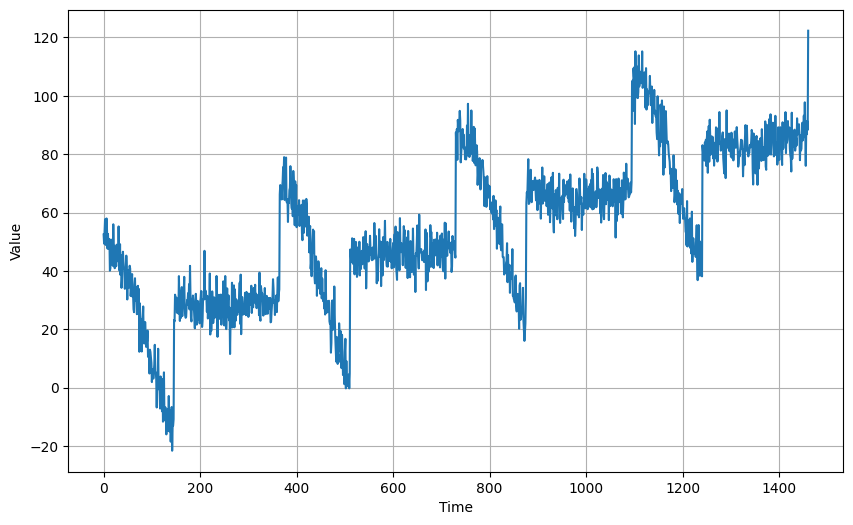

In [12]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [1]:
series

NameError: name 'series' is not defined

In [18]:

# for CNN, LSTM,
def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

#for RNN
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset




In [24]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [25]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)


In [27]:
model = keras.models.Sequential([
    keras.layers.Conv1D(filters=32, kernel_size=5,
                        strides=1, padding="causal",
                        activation="relu",
                        input_shape=[None, 1]),
    keras.layers.LSTM(32, return_sequences=True),
    keras.layers.LSTM(32, return_sequences=True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x * 200)
])
optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# model_checkpoint = keras.callbacks.ModelCheckpoint(
#     "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500
8/8 [==============================] - 11s 238ms/step - loss: 35.5581 - mae: 36.0555 - val_loss: 36.5331 - val_mae: 37.0318
Epoch 2/500
8/8 [==============================] - 0s 15ms/step - loss: 18.1908 - mae: 18.6849 - val_loss: 22.1330 - val_mae: 22.6310
Epoch 3/500
8/8 [==============================] - 0s 18ms/step - loss: 13.0979 - mae: 13.5899 - val_loss: 24.6460 - val_mae: 25.1438
Epoch 4/500
8/8 [==============================] - 0s 18ms/step - loss: 9.5606 - mae: 10.0491 - val_loss: 17.9143 - val_mae: 18.4108
Epoch 5/500
8/8 [==============================] - 0s 18ms/step - loss: 7.4918 - mae: 7.9764 - val_loss: 16.1049 - val_mae: 16.6002
Epoch 6/500
8/8 [==============================] - 0s 18ms/step - loss: 6.6096 - mae: 7.0927 - val_loss: 10.5316 - val_mae: 11.0202
Epoch 7/500
8/8 [==============================] - 0s 19ms/step - loss: 6.4358 - mae: 6.9185 - val_loss: 10.9702 - val_mae: 11.4606
Epoch 8/500
8/8 [==============================] - 0s 19ms/step - l